Note: this notebook is written to work in Colab, and thus it installs the `eigenlearning` repo from Github. If the repo is already present on the system, the install cell can be skipped and the modules imported directly, and the saving to Drive can be replaced with saving locally.

Another note: we assembled these notebooks out of modular parts from other notebooks, and thus we have not run all of them. If something doesn't work, let us know and we'll be glad to know and happy to fix it.

# Imports and installs

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import os
import sys

if os.path.isdir('/content/eigenlearning'):
  !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

     |████████████████████████████████| 92 kB 734 kB/s 


In [ ]:
import json
import math

import jax
from jax import grad
import jax.numpy as np
import jax.random as random

import matplotlib.gridspec as gridspec
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt

import numpy as basenp

In [ ]:
from utils import get_net_fns, net_predictions, kernel_predictions, mse
from measures import learning_measure_predictions, learning_measure_statistics, find_C
from unit_circle import unit_circle_eigenvalues, get_unit_circle_dataset
from hypercube import hypercube_eigenvalues, get_hypercube_dataset
from hypersphere import hypersphere_eigenvalues, get_hypersphere_dataset, hyp_har_multiplicity
from image_datasets import get_image_dataset

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Run experiment and save data

In [ ]:
main_dir = '/content/drive/DIRECTORY/mean_squared_gradient'

In [ ]:
for dir in [main_dir, main_dir+'/circle', main_dir+'/hypersphere']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

## Unit circle

### Helpers

In [ ]:
def mean_grad_square(y):
  mean_diff_square = ((y - np.roll(y, shift=1))**2).mean().item()
  d_theta = 2*np.pi / len(y)
  return mean_diff_square / d_theta**2

In [ ]:
def mean_grad_square_prediction(kernel_fn, k, n):
  target_f = {(k, 'c') : 1}
  all_modes = [{(i, 'c') : 1} for i in range(M//2 + 1)] + [{(i, 's') : 1} for i in range(1, (M-1)//2 + 1)]

  preds = learning_measure_predictions(net_fns[2], 'circle', n, target_f, all_modes, M=M)

  return sum([list(all_modes[i].keys())[0][0]**2 * (preds['g_coeffs'][i][0]**2 + preds['g_coeffs'][i][1]**2) for i in range(len(all_modes))])

In [ ]:
def mean_grad_square_statistics(net_fns, k, n, pred_type='kernel', exp_params=None):
  global key

  M = exp_params['M']
  target_f = {(k, 'c') : 1}
  all_modes = [{(i, 'c') : 1} for i in range(M//2 + 1)] + [{(i, 's') : 1} for i in range(1, (M-1)//2 + 1)]

  test_thetas, test_X, all_test_ys = get_unit_circle_dataset(M, [target_f] + all_modes)
  test_y, all_mode_ys = all_test_ys[0], all_test_ys[1:]
  
  m_g_ss = []
  for _ in range(exp_params['n_trials']):
    key, subkey1, subkey2 = random.split(key, 3)
    train_thetas, train_X, [train_y] = get_unit_circle_dataset(M, [target_f], full=False, n=n, subkey=subkey1)

    dataset = (train_X, train_y), (test_X, test_y)

    if pred_type == 'kernel':
      test_y_hat = kernel_predictions(net_fns[2], dataset)
    else:
      test_y_hat = net_predictions(net_fns,
                                   dataset,
                                   n_epochs=exp_params['n_epochs'],
                                   lr=exp_params['lr'],
                                   stop_mse=exp_params['stop_mse'],
                                   print_every=exp_params['print_every'],
                                   subkey=subkey2)['test_preds']

    m_g_ss += [mean_grad_square(test_y_hat)]
  
  m_g_ss = np.array(m_g_ss)
  return (m_g_ss.mean().item(), m_g_ss.std().item())

### Experiment

In [ ]:
key = random.PRNGKey(17)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

In [ ]:
M = 256
ks = [1, 2, 4, 8, 16]

ns_exp = [2**i for i in range(0,9)]
ns_th = np.logspace(np.log10(ns_exp[0]), np.log10(ns_exp[-1]))

In [ ]:
pred_msg, kernel_msg, net_msg = {}, {}, {}

In [ ]:
exp_params = {
    'M' : M,
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials' : 30
}

#### Compute theoretical predictions

In [ ]:
for k in ks:
  for i, n in enumerate(ns_th):
    if i % 10 == 0:
      print(k,n)
    pred_msg[str(k) + ',' + '%.3f'%n] = mean_grad_square_prediction(net_fns[2], k, n)

In [ ]:
with open(main_dir+'/circle/results_th.json', 'w') as file:
  json.dump(pred_msg, file)

#### Kernel experiments

In [ ]:
for k in ks:
  for n in ns_exp:
    print(k,n)
    kernel_msg[f'{k},{n}'] = mean_grad_square_statistics(net_fns, k, n, pred_type='kernel', exp_params=exp_params)

In [ ]:
with open(main_dir+'/circle/results_kernel.json', 'w') as file:
  json.dump(kernel_msg, file)

#### Net experiments

In [ ]:
for k in ks:
  for n in ns_exp:
    net_msg[f'{k},{n}'] = mean_grad_square_statistics(net_fns, k, n, pred_type='net', exp_params=exp_params)

In [ ]:
with open(main_dir+'/circle/results_net.json', 'w') as file:
  json.dump(net_msg, file)

## Hypersphere

### Helpers

In [ ]:
def hypersphere_mean_grad_square_prediction(kernel_fn, d, k, n):
  target_f = {k : 1}
  all_modes = [{i : 1} for i in range(70)]
  preds = learning_measure_predictions(kernel_fn, 'hypersphere', n, target_f, all_modes, d=d)

  return sum(list([k * (k + d - 2) * (preds['g_coeffs'][k][0]**2 + hyp_har_multiplicity(d, k) * preds['g_coeffs'][k][1]**2) for k in range(len(all_modes))]))

In [ ]:
def hypersphere_mean_grad_square_statistics(net_fns, d, k, n, exp_params):
  target_f = {k : 1}
  
  msgs, mgs, mses_tr, mses_te = [], [], [], []
  for _ in range(exp_params['n_trials']):
    global key
    key, subkey1, subkey2, subkey3 = random.split(key, 4)
    train_X, train_y = get_hypersphere_dataset(d, [target_f], n, subkey1)
    test_X, test_y = get_hypersphere_dataset(d, [target_f], exp_params['n_test'], subkey2)
    train_y, test_y = train_y[0], test_y[0]
    dataset = (train_X, train_y), (test_X, test_y)

    results = net_predictions(
        net_fns,
        dataset,                       
        n_epochs=exp_params['n_epochs'],
        lr=exp_params['lr'],
        stop_mse=exp_params['stop_mse'],
        print_every=exp_params['print_every'],
        return_params=True,
        subkey=subkey3
        )
    
    apply_fn, params = results['apply_fn'], results['params']
    input_grad = grad(lambda X: apply_fn(params, X).sum())

    grads = input_grad(test_X)
    radial_projections = (grads * test_X).sum(axis=1)[:,None] * test_X
    orthograds = grads - radial_projections
    msgs += [(orthograds**2).sum(axis=1).mean().item()]
    mgs += [((orthograds**2).sum(axis=1)**.5).mean().item()]
    mses_tr += [mse(train_y, results['train_preds'])]
    mses_te += [mse(test_y, results['test_preds'])]
  
  msgs, mgs, mses_tr, mses_te = [np.array(arr) for arr in [msgs, mgs, mses_tr, mses_te]]
  results = {msr : (arr.mean().item(), arr.std().item()) for (msr, arr) in zip(['msg', 'mg', 'mse_tr', 'mse_te'], [msgs, mgs, mses_tr, mses_te])}

  return results

### Setup

In [ ]:
key = random.PRNGKey(17)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

In [ ]:
ns_exp = [2**i for i in range(0,4)]
ns_th = np.logspace(np.log10(ns_exp[0]), np.log10(ns_exp[-1]))

In [ ]:
ds = [3, 5, 8]
ks = [2, 3]

In [ ]:
exp_params = {
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': 1000,
    'n_trials' : 30,
    'n_test' : 5000
}

### Theory

In [ ]:
pred_msg = {}

In [ ]:
for d in ds:
  for k in ks:
    for i, n in enumerate(ns_th):
      if i % 10 == 0:
        print(d,k,n)
      pred_msg[str(d) + ',' + str(k) + ',' + '%.3f'%n] = hypersphere_mean_grad_square_prediction(net_fns[2], d, k, n)

In [ ]:
with open(main_dir+'/hypersphere/results_th.json', 'w') as file:
  json.dump(pred_msg, file)

### Net Experiments

In [ ]:
net_msg = {}

In [ ]:
for d in ds:
  for k in ks:
    print(d,k)
    for n in ns_exp:
      net_msg[f'{d},{k},{n}'] = hypersphere_mean_grad_square_statistics(net_fns, d, k, n, exp_params)

In [ ]:
with open(main_dir+'/hypersphere/results_net.json', 'w') as file:
  json.dump(net_msg, file)

# Load data and make figures

##### Read in results

In [ ]:
results = {domain:{'th':{},'kernel':{},'net':{}} for domain in domains}

with open(main_dir + 'I/circle/results_th.json', 'r') as file:
  results['circle']['th'] = json.load(file)
with open(main_dir + 'I/circle/results_kernel.json', 'r') as file:
  results['circle']['kernel'] = json.load(file)
with open(main_dir + 'I/circle/results_net.json', 'r') as file:
  results['circle']['net'] = json.load(file)

with open(main_dir + 'I/hypersphere/results_th.json', 'r') as file:
  results['hypersphere']['th'] = json.load(file)
with open(main_dir + 'I/hypersphere/results_net.json', 'r') as file:
  results['hypersphere']['net'] = json.load(file)

##### Convert results from string keys to tuple keys

In [ ]:
for domain in domains:
  for rtype in ['th','kernel','net']:
    keys = list(results[domain][rtype].keys())
    for key in keys:
      if isinstance(key, str):
        if domain == 'circle':
          k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
          results[domain][rtype][(k, n)] = results[domain][rtype][key]
        elif domain == 'hypersphere':
          d, k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
          results[domain][rtype][(d, k, n)] = results[domain][rtype][key]
        del results[domain][rtype][key]

##### Extract some metadata

In [ ]:
metadata = {domain : {key : {} for key in results[domain].keys()} for domain in domains}

for domain in domains:
  for rtype in metadata[domain].keys():
    if domain == 'circle':
      metadata[domain][rtype]['ks'] = sorted(list(set([key[0] for key in results[domain][rtype]])))
      metadata[domain][rtype]['ns'] = sorted(list(set([key[1] for key in results[domain][rtype]])))
    elif domain == 'hypersphere':
      metadata[domain][rtype]['ds'] = sorted(list(set([key[0] for key in results[domain][rtype]])))
      metadata[domain][rtype]['ks'] = sorted(list(set([key[1] for key in results[domain][rtype]])))
      metadata[domain][rtype]['ns'] = sorted(list(set([key[2] for key in results[domain][rtype]])))

## Unit Circle

In [ ]:
ks = metadata['circle']['th']['ks']
colors = {ks[i] : hsv_to_rgb(([0,.17,.4,.6,.8,.9][i],1,.7)) for i in range(len(ks))}

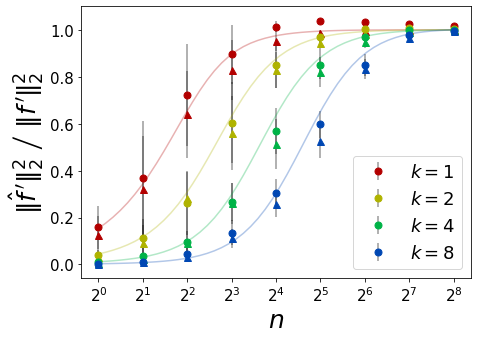

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

for k in ks:
  if k == 16:
    continue
  
  ns_th = [n for n in metadata['circle']['th']['ns'] if n >= 1]
  ns_exp = np.array([n for n in metadata['circle']['kernel']['ns'] if n >= 1])

  msg_th = np.array([results['circle']['th'][(k, n)] for n in ns_th])
  msg_k_mean, msg_k_std = np.array([results['circle']['kernel'][(k, n)] for n in ns_exp]).T
  msg_n_mean, msg_n_std = np.array([results['circle']['net'][(k, n)] for n in ns_exp]).T

  msg_th, msg_k_mean, msg_k_std, msg_n_mean, msg_n_std = msg_th / k**2, msg_k_mean / k**2, msg_k_std / k**2, msg_n_mean / k**2, msg_n_std / k**2

  ax.errorbar(ns_exp, msg_n_mean, yerr=msg_n_std, fmt='o', color=colors[k], ecolor=(0,0,0,.3), markersize=7, elinewidth=2, label=f'$k={k}$')
  ax.errorbar(ns_exp, msg_k_mean, yerr=msg_k_std, fmt='^', color=colors[k], ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
  ax.plot(ns_th, msg_th, color=opacify(colors[k], alpha=.3))

ax.set_xscale('log')
ax.set_xticks([2**i for i in range(round(math.log2(ns_exp[0])), round(math.log2(ns_exp[-1])+1))], minor=False)
ax.set_xticks([], minor=True)
ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(round(math.log2(ns_exp[0])), round(math.log2(ns_exp[-1])+1))], minor=False)
ax.set_xticklabels([], minor=True)

ax.set_xlabel('$n$', fontsize=25)
ax.set_ylabel("$| \\! |\\hat{f} \\, '| \\! \\left.  |_2^2 \\ \\right/ \\ | \\! |f \\, '| \\! |_2^2$", fontsize=25)

ax.legend(fontsize=18)
ax.tick_params(labelsize=15)

plt.savefig('mean_squared_gradient_circle.pdf', bbox_inches='tight')

## Hypersphere

In [ ]:
ds = metadata['hypersphere']['th']['ds']
ks = metadata['hypersphere']['th']['ks']
ns_th = [n for n in metadata['hypersphere']['th']['ns']]
ns_exp = np.array([n for n in metadata['hypersphere']['net']['ns']])

colors = {ds[i] : hsv_to_rgb(([0,.17,.4,.6,.8,.9][i],1,.7)) for i in range(len(ds))}

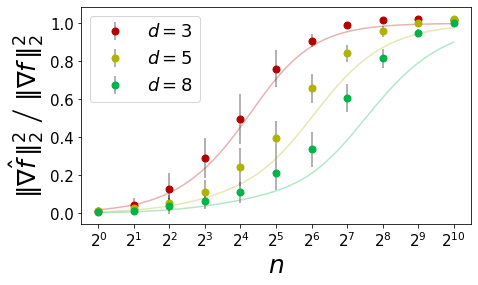

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))

k = 2

for d in ds:
  
  msg_th = np.array([results['hypersphere']['th'][(d, k, n)] for n in ns_th])
  
  msg_n_mean, msg_n_std = np.array([results['hypersphere']['net'][(d, k, n)]['msg'] for n in ns_exp]).T

  msg_th, msg_n_mean, msg_n_std = msg_th / (k * (k + d - 2)), msg_n_mean / (k * (k + d - 2)), msg_n_std / (k * (k + d - 2))

  ax.errorbar(ns_exp, msg_n_mean, yerr=msg_n_std, fmt='o', color=colors[d], ecolor=(0,0,0,.3), markersize=7, elinewidth=2, label=f'$d={d}$')

  ax.plot(ns_th, msg_th, color=opacify(colors[d], alpha=.3))

ax.set_xscale('log')
ax.set_xticks([2**i for i in range(round(math.log2(ns_exp[0])), round(math.log2(ns_exp[-1])+1))], minor=False)
ax.set_xticks([], minor=True)
ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(round(math.log2(ns_exp[0])), round(math.log2(ns_exp[-1])+1))], minor=False)
ax.set_xticklabels([], minor=True)

ax.set_xlabel('$n$', fontsize=25)
ax.set_ylabel("$| \\! | \\nabla \\hat{f} \\, | \\! \\left.  |_2^2 \\ \\right/ \\ | \\! | \\nabla f \\, | \\! |_2^2$", fontsize=25)

ax.legend(fontsize=18)
ax.tick_params(labelsize=15)

plt.savefig('mean_squared_gradient_sphere.pdf', bbox_inches='tight')